In [71]:
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
#load data
with open("/home/vrlab/Documents/HS/Hearthstone_Winrate/dataset/hsreply_data/decks.json", 'r') as f:
    decks_ori = json.load(f)

winrate = []
decks = []
cards = set()

for deck in decks_ori:
    tmp = []
    for card in deck['deck_list']:
        for i in range(card[1]):
            tmp.append(card[0])
    if len(tmp) == 30:
        decks.append(tmp)
        for card in tmp:
            cards.add(card)
        winrate.append(deck['win_rate']/100)

cards = list(cards)

print('cards num:', len(cards))
print('decks num:', len(decks))
print('deck example:', decks[0])
print(winrate[0])

cards num: 958
decks num: 736
deck example: [99957, 99957, 97467, 97467, 100595, 100595, 97406, 97683, 98283, 98283, 98285, 98762, 98762, 97282, 97282, 85154, 85154, 79780, 97528, 97528, 98768, 98768, 86626, 80647, 80647, 101375, 97269, 97269, 97394, 97394]
0.7648


In [3]:
# one hot encode
mapping = np.eye(len(cards))
print(cards)
cards = {cards[i]:mapping[i] for i in range(len(cards))}

decks = [[cards[card] for card in deck] for deck in decks]

decks = np.array(decks)
print(decks.shape)

[69632, 69635, 69636, 69637, 100358, 69638, 71688, 100361, 100362, 100363, 71690, 100365, 71694, 100367, 69643, 100369, 69649, 94225, 69654, 69655, 98328, 71705, 69658, 69660, 69663, 71712, 69665, 84003, 69668, 69667, 84007, 98344, 81961, 94248, 81963, 94251, 69674, 73774, 69683, 81972, 81973, 69684, 69688, 69689, 69691, 79932, 96077, 92222, 92225, 69698, 69700, 92228, 69702, 69703, 92232, 69705, 69706, 92235, 69707, 98377, 98382, 92237, 86092, 69713, 92240, 69718, 69721, 92250, 92249, 75866, 75868, 86109, 86111, 92256, 86112, 69625, 98403, 69731, 71781, 69734, 69735, 86120, 75881, 92266, 98411, 69740, 92268, 69742, 92267, 98417, 98123, 69629, 86132, 69630, 98427, 98434, 86150, 80014, 82067, 80021, 96909, 82072, 82073, 84292, 71841, 84132, 98469, 96422, 92325, 82088, 69640, 92332, 94381, 86190, 92335, 69641, 73906, 92338, 92340, 100537, 100539, 100540, 86209, 100546, 82116, 100553, 102212, 80083, 80085, 98520, 80089, 80090, 86235, 80091, 73721, 102214, 102215, 71917, 102218, 84206, 719

In [63]:
# Dataloader
inputs = torch.tensor(decks, dtype=torch.float).to('cuda')
gts = torch.tensor(winrate, dtype=torch.float).to('cuda')

train_dataset = TensorDataset(inputs, gts)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [77]:
class SA(nn.Module):
    def __init__(self, input_dim, dim_k, dim_v):
        super(SA, self).__init__()
        # Attention
        self.cal_q = nn.Linear(input_dim, dim_k)
        self.cal_k = nn.Linear(input_dim, dim_k)
        self.cal_v = nn.Linear(input_dim, dim_v)
        nn.init.kaiming_normal(self.cal_q.weight, nonlinearity='relu')
        nn.init.kaiming_normal(self.cal_k.weight, nonlinearity='relu')
        nn.init.kaiming_normal(self.cal_v.weight, nonlinearity='relu')
        self.scale = 1 / sqrt(dim_k)

        # Regression
        self.fc1 = nn.Linear(2*30*dim_v, 4096)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1)
        self.fc3 = nn.Linear(4096, 512)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        Q = self.cal_q(x)
        K = self.cal_k(x)
        V = self.cal_v(x)
        atten = nn.Softmax(dim=-1)(torch.bmm(Q,K.permute(0,2,1))) * self.scale
        out = torch.bmm(atten,V)
        out = torch.concat([out, x], dim=2)
        out = out.view(x.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)

        return out

In [78]:
input_size = len(cards)
hidden_size = 1024
output_size = 1
model = SA(input_size, input_size, input_size).to('cuda:0')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

/tmp/ipykernel_5530/1058886540.py:8: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.cal_q.weight, nonlinearity='relu')
/tmp/ipykernel_5530/1058886540.py:9: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.cal_k.weight, nonlinearity='relu')
/tmp/ipykernel_5530/1058886540.py:10: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.cal_v.weight, nonlinearity='relu')


In [79]:
num_epochs = 1000
losses = []
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    # 前向传播
    for input, gt in train_loader:
        # 前向传播
        outputs = model(input)
        loss = criterion(outputs, gt.view(-1, 1))

        # 反向传播和优化
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        optimizer.zero_grad()
        # scheduler.step()
        running_loss += loss.item()
    
    losses.append(running_loss)

    # plt.plot(losses, marker='o')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Loss Change Over Epochs')
    plt.show()
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.5f}')
        with torch.no_grad():
            idxs = random.choices(range(len(inputs)), k=2)
            test_outputs = model(inputs[idxs])
            for i in range(2):
                print(f'pred: {test_outputs[i]}, gt: {gts[idxs[i]]}')


torch.save(model.state_dict(), 'model_weights.pth')



  5%|▌         | 50/1000 [01:03<20:10,  1.27s/it]

Epoch [50/1000], Loss: 2.57376
pred: tensor([0.5104], device='cuda:0'), gt: 0.6376000046730042
pred: tensor([0.5102], device='cuda:0'), gt: 0.49619999527931213


 10%|█         | 100/1000 [02:07<19:06,  1.27s/it]

Epoch [100/1000], Loss: 2.20025
pred: tensor([0.5222], device='cuda:0'), gt: 0.5906999707221985
pred: tensor([0.5212], device='cuda:0'), gt: 0.4593000113964081


 15%|█▌        | 150/1000 [03:10<18:02,  1.27s/it]

Epoch [150/1000], Loss: 1.91813
pred: tensor([0.5318], device='cuda:0'), gt: 0.5983999967575073
pred: tensor([0.5318], device='cuda:0'), gt: 0.7063999772071838


 20%|██        | 200/1000 [04:14<16:58,  1.27s/it]

Epoch [200/1000], Loss: 1.70480
pred: tensor([0.5412], device='cuda:0'), gt: 0.6766999959945679
pred: tensor([0.5411], device='cuda:0'), gt: 0.5368000268936157


 25%|██▌       | 250/1000 [05:18<15:55,  1.27s/it]

Epoch [250/1000], Loss: 1.54324
pred: tensor([0.5495], device='cuda:0'), gt: 0.6317999958992004
pred: tensor([0.5491], device='cuda:0'), gt: 0.5849000215530396


 30%|███       | 300/1000 [06:21<14:51,  1.27s/it]

Epoch [300/1000], Loss: 1.42063
pred: tensor([0.5548], device='cuda:0'), gt: 0.5679000020027161
pred: tensor([0.5567], device='cuda:0'), gt: 0.6700999736785889


 35%|███▌      | 350/1000 [07:25<13:47,  1.27s/it]

Epoch [350/1000], Loss: 1.32738
pred: tensor([0.5609], device='cuda:0'), gt: 0.5419999957084656
pred: tensor([0.5606], device='cuda:0'), gt: 0.5318999886512756


 40%|████      | 400/1000 [08:29<12:44,  1.27s/it]

Epoch [400/1000], Loss: 1.25631
pred: tensor([0.5661], device='cuda:0'), gt: 0.6157000064849854
pred: tensor([0.5657], device='cuda:0'), gt: 0.6132000088691711


 45%|████▌     | 450/1000 [09:32<11:40,  1.27s/it]

Epoch [450/1000], Loss: 1.20204
pred: tensor([0.5713], device='cuda:0'), gt: 0.5670999884605408
pred: tensor([0.5719], device='cuda:0'), gt: 0.663100004196167


 50%|█████     | 500/1000 [10:36<10:36,  1.27s/it]

Epoch [500/1000], Loss: 1.16048
pred: tensor([0.5748], device='cuda:0'), gt: 0.6040999889373779
pred: tensor([0.5756], device='cuda:0'), gt: 0.6596999764442444


 55%|█████▌    | 550/1000 [11:40<09:33,  1.27s/it]

Epoch [550/1000], Loss: 1.12859
pred: tensor([0.5776], device='cuda:0'), gt: 0.626800000667572
pred: tensor([0.5779], device='cuda:0'), gt: 0.6100000143051147


 60%|██████    | 600/1000 [12:43<08:29,  1.27s/it]

Epoch [600/1000], Loss: 1.10404
pred: tensor([0.5811], device='cuda:0'), gt: 0.592199981212616
pred: tensor([0.5806], device='cuda:0'), gt: 0.6168000102043152


 65%|██████▌   | 650/1000 [13:47<07:25,  1.27s/it]

Epoch [650/1000], Loss: 1.08509
pred: tensor([0.5832], device='cuda:0'), gt: 0.5892000198364258
pred: tensor([0.5849], device='cuda:0'), gt: 0.620199978351593


 70%|███████   | 700/1000 [14:50<06:15,  1.25s/it]

Epoch [700/1000], Loss: 1.07041
pred: tensor([0.5876], device='cuda:0'), gt: 0.6499999761581421
pred: tensor([0.5860], device='cuda:0'), gt: 0.5791000127792358


 75%|███████▌  | 750/1000 [15:53<05:18,  1.27s/it]

Epoch [750/1000], Loss: 1.05898
pred: tensor([0.5885], device='cuda:0'), gt: 0.6525999903678894
pred: tensor([0.5869], device='cuda:0'), gt: 0.4742000102996826


 80%|████████  | 800/1000 [16:57<04:12,  1.26s/it]

Epoch [800/1000], Loss: 1.05003
pred: tensor([0.5890], device='cuda:0'), gt: 0.6883000135421753
pred: tensor([0.5894], device='cuda:0'), gt: 0.5837000012397766


 85%|████████▌ | 850/1000 [17:59<03:07,  1.25s/it]

Epoch [850/1000], Loss: 1.04298
pred: tensor([0.5888], device='cuda:0'), gt: 0.4805000126361847
pred: tensor([0.5907], device='cuda:0'), gt: 0.5644000172615051


 90%|█████████ | 900/1000 [19:02<02:05,  1.25s/it]

Epoch [900/1000], Loss: 1.03737
pred: tensor([0.5922], device='cuda:0'), gt: 0.6165000200271606
pred: tensor([0.5913], device='cuda:0'), gt: 0.5364999771118164


 95%|█████████▌| 950/1000 [20:04<01:02,  1.25s/it]

Epoch [950/1000], Loss: 1.03287
pred: tensor([0.5941], device='cuda:0'), gt: 0.6571000218391418
pred: tensor([0.5954], device='cuda:0'), gt: 0.6552000045776367


100%|██████████| 1000/1000 [21:07<00:00,  1.27s/it]

Epoch [1000/1000], Loss: 1.02922
pred: tensor([0.5933], device='cuda:0'), gt: 0.6144999861717224
pred: tensor([0.5931], device='cuda:0'), gt: 0.5311999917030334


In [81]:
with torch.no_grad():
    inputs = inputs
    test_outputs = model(inputs)
    print(test_outputs.shape)
    for i in range(len(test_outputs)):
        print(f"pred: {test_outputs[i]} gt: {gts[i]}")

    mse = criterion(test_outputs, gts)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

torch.Size([736, 1])
pred: tensor([0.5955], device='cuda:0') gt: 0.7648000121116638
pred: tensor([0.5937], device='cuda:0') gt: 0.7613000273704529
pred: tensor([0.5947], device='cuda:0') gt: 0.7329999804496765
pred: tensor([0.5946], device='cuda:0') gt: 0.7210000157356262
pred: tensor([0.5951], device='cuda:0') gt: 0.6894999742507935
pred: tensor([0.5951], device='cuda:0') gt: 0.6823999881744385
pred: tensor([0.5951], device='cuda:0') gt: 0.6811000108718872
pred: tensor([0.5933], device='cuda:0') gt: 0.675599992275238
pred: tensor([0.5951], device='cuda:0') gt: 0.6744999885559082
pred: tensor([0.5947], device='cuda:0') gt: 0.6722000241279602
pred: tensor([0.5944], device='cuda:0') gt: 0.6699000000953674
pred: tensor([0.5950], device='cuda:0') gt: 0.6669999957084656
pred: tensor([0.5955], device='cuda:0') gt: 0.6654000282287598
pred: tensor([0.5945], device='cuda:0') gt: 0.6599000096321106
pred: tensor([0.5951], device='cuda:0') gt: 0.6546000242233276
pred: tensor([0.5940], device='cuda

/home/vrlab/anaconda3/envs/hs/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([736])) that is different to the input size (torch.Size([736, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


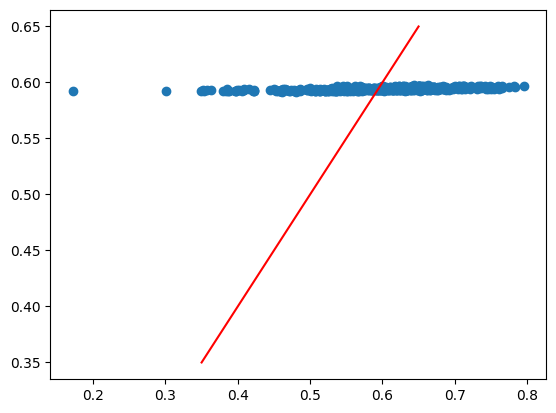

array([[1.        , 0.36063417],
       [0.36063417, 1.        ]])

In [85]:
plt.scatter(winrate,test_outputs.cpu())
plt.plot(np.arange(0.35,.7,0.05),np.arange(0.35,.7,0.05), color='red')
plt.show()

np.corrcoef(winrate,test_outputs.view(-1).cpu())**2

In [37]:
avg_winrate = sum(winrate)/ len(winrate)
print(avg_winrate)

0.6013101902173915
